<a id='summary'></a>
# IPU synthpop over mobiles

* takes census with statistially matched agendas
* Rescale census to fit the observed number of trips per hour in orange data


## Summary
* [Loading data](#data)
    * [Loading activity chains](#agendas)
    * [Loading census with agendas](#census)
    * [Loading socio-eco marginals](#socioeco_marginals)
    * [Getting chain_len marginals](#chainlen)
    * [Loading Orange ODs](#od)
    
    
* [Pre-visualisation](#previz)


* [IPU](#ipu)


* [Integrating results](#integration)


* [Exportation](#export)


* [Visualisation](#viz)



In [1]:
import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 
import warnings

import torch
from torch import nn
from tqdm import tqdm

from utils.chrono import Chrono

with open('config.json', 'r') as config_path:
    config = json.load(config_path)
    
per_cols = config['per_cols_rescaling']  # Define the socio-eco vars we will consider in the rescaling
timesteps = np.array(config['timesteps'])
print(per_cols)

['gender', 'has_car', 'occupation', 'age']


In [2]:
fac_font = 2.5
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10*fac_font,
    "font.size": 10*fac_font,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8*fac_font,
    "xtick.labelsize": 8*fac_font,
    "ytick.labelsize": 8*fac_font
}
plt.rcParams.update(tex_fonts)

<a id='data'></a>
# Loading data

<a id='agendas'></a>
## Loading activity chains from EGT
* [back to summary](#summary)

In [3]:
activity_chain_path = os.path.join(config['outdata_dir']['path'], 
                                   config['outdata_dir']['activity_chains_filename'])
print('Loading activity chains from {}'.format(activity_chain_path))
activity_chains = pd.read_csv(activity_chain_path)
activity_chains['chain_len'] = activity_chains['chain_len'].astype(int)
max_chain_len = activity_chains['chain_len'].max()

Loading activity chains from /Users/benoit/Desktop/Pro/210526-fusion/outdata/synthpop/activity_chains.csv


### Defining trip variables
* Trips are defined by their time step and dist bin
* But the values are not joint, since the targets are not joint (we have a target for distances derived from HTS and a target for timestep derived from OD matrices)

In [4]:
distbin_limits = config['distbin_limits'] + [np.inf]
distbins = np.arange(len(distbin_limits)-1)

In [5]:
for ts in timesteps:
    activity_chains['ts_{}'.format(ts)] = 0
    
for bin_col in distbins:
    activity_chains['distbin_{}'.format(bin_col)] = 0
    
for i in range(1, max_chain_len+1):
    for ts in timesteps:
        activity_chains.loc[activity_chains['dep_{}_time'.format(i)]==ts, 'ts_{}'.format(ts)] += 1
        
    for bin_col in distbins:
        activity_chains.loc[activity_chains['dep_{}_distbin'.format(i)]==bin_col, 'distbin_{}'.format(bin_col)] += 1
        
distbin_cols = ['distbin_{}'.format(bin_col) for bin_col in distbins]
ts_cols = ['ts_{}'.format(ts) for ts in timesteps]
mod_trips_cols = ts_cols + distbin_cols

<a id='census'></a>
## Loading synthpop
* Load synthpop results from previous notebook and define the socio-eco modalities
* Join synthetic agents with their agendas
* [back to summary](#summary)

In [6]:
synthpop_path = os.path.join(config['outdata_dir']['path'], 
                            config['outdata_dir']['synthpop_statmatch_filename'])

c = Chrono('Loading synthpop from {}...'.format(synthpop_path))


synthpop = pd.read_csv(synthpop_path, dtype={'iris_or_commune':str})#.sample(10000)
synthpop['has_car'] = synthpop['has_car'].astype(int)
synthpop['age'] = synthpop['age'].astype(int)
c.write('{} rows'.format(len(synthpop)))

c.write('Joining synthetic agents with their agendas...')
len_before = len(synthpop)
synthpop = synthpop.merge(activity_chains, left_on='id_agenda', right_on='id_per')
if len_before != len(synthpop):
    c.warn('/!\ synthpop with activity chains has {} rows while synthpop has {}'.format(len(synthpop), len_before))

c.write('{} synthetic agents'.format(len(synthpop)))

c.write('Getting all distinct joint modalities of socio-eco vars in census...')
synthpop['mod_socio_eco'] = synthpop[per_cols].apply(lambda r: str(tuple(r)), axis=1)
mod_socio_eco_cols = list(synthpop['mod_socio_eco'].unique())
c.write('Some socio-eco modalities: {}'.format(mod_socio_eco_cols[:3]))

c.write('Dummifying mod_socio_eco...')
synthpop = pd.get_dummies(synthpop, 'mod_socio_eco')
synthpop = synthpop.rename(columns={'mod_socio_eco_{}'.format(col):col for col in mod_socio_eco_cols})
synthpop = synthpop[['id_agenda'] + mod_socio_eco_cols + mod_trips_cols + ['chain_len']]

c.write('Assigning an ID to each pre-rescaled agent...')
synthpop['id_per'] = np.arange(len(synthpop))

c.write('Grouping equivalent agents (same socioeco and trip hours)...')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    synthpop_gr = (synthpop
               .groupby(mod_socio_eco_cols + mod_trips_cols + ['chain_len'])
               .agg({'id_per':list, 'chain_len':'count'})
               .rename(columns={'chain_len':'vol'}).reset_index())
id_list = synthpop_gr['id_per'].copy()
group_sizes = id_list.str.len()  # size of the group of equivalent synthetic agents

synthpop_gr = synthpop_gr.drop(columns=['id_per'])

c.write('{} groups'.format(len(synthpop_gr)))
c.write('Dummifying chain_len...')
synthpop_gr['chain_len'] = synthpop_gr['chain_len'].astype(str)


synthpop_gr = pd.get_dummies(synthpop_gr, 'chain_len')


mod_agenda_cols = [col for col in synthpop_gr if col.startswith('chain_len')]

c.done()

display(synthpop.head())


15:59:39	Loading synthpop from /Users/benoit/Desktop/Pro/210526-fusion/outdata/synthpop/synthpop_statmatch.csv...
00:00:00	1325654 rows
00:00:00	Joining synthetic agents with their agendas...
00:00:03	1325654 synthetic agents
00:00:03	Getting all distinct joint modalities of socio-eco vars in census...
00:00:12	Some socio-eco modalities: ['(0, 1, 8, 3)', '(0, 1, 6, 1)', '(1, 1, 4, 2)']
00:00:12	Dummifying mod_socio_eco...
00:00:30	Assigning an ID to each pre-rescaled agent...
00:00:30	Grouping equivalent agents (same socioeco and trip hours)...
00:00:40	205904 groups
00:00:40	Dummifying chain_len...
00:00:40	Work complete !


,id_agenda,"(0, 1, 8, 3)","(0, 1, 6, 1)","(1, 1, 4, 2)","(0, 1, 6, 2)","(1, 1, 7, 0)","(0, 1, 7, 0)","(0, 1, 5, 2)","(0, 1, 3, 2)","(0, 1, 7, 1)",...,distbin_0,distbin_1,distbin_2,distbin_3,distbin_4,distbin_5,distbin_6,distbin_7,chain_len,id_per
0,1320021221,True,False,False,False,False,False,False,False,False,...,0,0,0,3,0,0,2,0,5,0
1,1320021221,False,True,False,False,False,False,False,False,False,...,0,0,0,3,0,0,2,0,5,1
2,1320021221,False,False,True,False,False,False,False,False,False,...,0,0,0,3,0,0,2,0,5,2
3,1320021221,False,False,False,True,False,False,False,False,False,...,0,0,0,3,0,0,2,0,5,3
4,1320021221,False,False,False,False,True,False,False,False,False,...,0,0,0,3,0,0,2,0,5,4


<a id='socioeco_marginals'></a>
## Loading socio-eco marginals
* Gotten from census in the preprocessing notebook

In [7]:
socioeco_marginal_path = os.path.join(config['outdata_dir']['path'], 
                                      config['outdata_dir']['socioeco_marginals_filename'])
print(socioeco_marginal_path)
socioeco_marginal_df = pd.read_csv(socioeco_marginal_path)

socioeco_marginal_df = socioeco_marginal_df.groupby(per_cols)['IPONDI'].sum().reset_index()
socioeco_marginal_df['mod_socio_eco'] = socioeco_marginal_df[per_cols].apply(lambda r: str(tuple(r)), axis=1)

# making sure we have all socio-eco modalities in the marginals:
socioeco_marginal_df = pd.DataFrame({'mod_socio_eco':mod_socio_eco_cols}).merge(socioeco_marginal_df, 
                                                                                   on='mod_socio_eco', how='left')
socioeco_marginal_df = socioeco_marginal_df.rename(columns={'IPONDI':'vol'})[['mod_socio_eco', 'vol']]

# making sure rows are in right order, even if it should already be ok
socioeco_marginal_df = socioeco_marginal_df.set_index('mod_socio_eco').loc[mod_socio_eco_cols].reset_index()

socioeco_marginal_df = socioeco_marginal_df.rename(columns={'mod_socio_eco':'marginal'})
socioeco_marginal_df

/Users/benoit/Desktop/Pro/210526-fusion/outdata/synthpop/marginals.csv


,marginal,vol
0,"(0, 1, 8, 3)",73375.964476
1,"(0, 1, 6, 1)",18460.655076
2,"(1, 1, 4, 2)",59278.344833
3,"(0, 1, 6, 2)",45243.933187
4,"(1, 1, 7, 0)",109977.844915
...,...,...
122,"(1, 0, 6, 0)",18.305805
123,"(0, 0, 4, 0)",14.843467
124,"(0, 0, 1, 1)",9.804574
125,"(1, 1, 3, 0)",4.143235


<a id='chainlen'></a>
## `chain_len` marginal
* [back to summary](#summary)

In [8]:

egt_path = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['HTS_filtered_filename'])
print(egt_path)

egt = pd.read_csv(egt_path, dtype={'zf_home':str})
egt = egt.groupby(['id_per']).first().reset_index()
print('{} persons in egt'.format(len(egt)))

egt = egt.merge(activity_chains[['id_per', 'chain_len']], on='id_per')
print('{} persons in egt with an activity chain'.format(len(egt)))

chainlen_marginal_df = egt.groupby('chain_len')['scaling_factor_person'].sum()
# re-sorting so it's in the same order as the column names (ie 12 is before 2 because str)
chainlen_marginal_df = chainlen_marginal_df.reset_index()
chainlen_marginal_df['chain_len'] = chainlen_marginal_df['chain_len'].astype(str)
chainlen_marginal_df = chainlen_marginal_df.sort_values('chain_len')

chainlen_marginal_df = chainlen_marginal_df.rename(columns={'chain_len':'marginal', 'scaling_factor_person':'vol'})
chainlen_marginal_df['marginal'] = chainlen_marginal_df['marginal'].apply(lambda x:'chain_len_{}'.format(x))
chainlen_marginal_df

/Users/benoit/Desktop/Pro/210526-fusion/outdata/egt_lyon_pop_sample/egt_lyon_pop_sample.csv
18572 persons in egt
16941 persons in egt with an activity chain


,marginal,vol
0,chain_len_0,264823.70192
1,chain_len_1,20447.70098
10,chain_len_10,365.25388
2,chain_len_2,520026.99283
3,chain_len_3,98585.11988
4,chain_len_4,243322.28575
5,chain_len_5,52059.17557
6,chain_len_6,37871.11252
7,chain_len_7,8842.29310
8,chain_len_8,2736.97907


<a id='distbin'></a>
## `distbin` marginal
* [back to summary](#summary)

In [9]:
distbin_marginal_df = (synthpop[distbin_cols].sum(axis=0).reset_index()
                       .rename(columns={'index':'marginal', 0:'vol'}))

distbin_marginal_df

,marginal,vol
0,distbin_0,452198
1,distbin_1,180559
2,distbin_2,401061
3,distbin_3,857088
4,distbin_4,474830
5,distbin_5,283720
6,distbin_6,176208
7,distbin_7,259997


<a id='od'></a>
## Loading trips by hour maginals from Orange data
* See notebook `Transition matrices`
* [back to summary](#summary)

In [10]:
# # From un-anonymised OD-matrices
trips_by_hour_odm_path = os.path.join(config['outdata_dir']['path'], 
                                      config['outdata_dir']['trips_by_hour_filename'])
print(trips_by_hour_odm_path)

trips_by_hour_odm = pd.read_csv(trips_by_hour_odm_path)

trips_by_hour_marginal_df = trips_by_hour_odm.rename(columns={'t':'marginal'})

trips_by_hour_marginal_df['marginal'] = trips_by_hour_marginal_df['marginal'].apply(lambda x:'ts_{:.0f}'.format(x))


print('total volume of trips from OD matrices : ', trips_by_hour_odm['vol'].sum())
trips_by_hour_marginal_df

/Users/benoit/Desktop/Pro/210526-fusion/outdata/trips_by_hour_odm_unanon.csv
total volume of trips from OD matrices :  1787219.0412896487


,marginal,vol
0,ts_0,25930.507394
1,ts_2,14636.049557
2,ts_5,67479.221410
3,ts_7,122980.319828
4,ts_8,144446.695012
5,ts_9,93518.942559
6,ts_10,180189.779558
7,ts_12,225904.491855
8,ts_14,199975.603515
9,ts_16,127340.717484


## Uniform rescaling coefs

In [11]:
X_socio = socioeco_marginal_df['vol'].values
Y_socio = synthpop_gr['vol'].values @ synthpop_gr[mod_socio_eco_cols].values
coef_socio = Y_socio.sum()/X_socio.sum()
print('coefficient de droite (passant par 0), fittant socio eco : {:.5f}\n'.format(coef_socio))

X_timesteps = trips_by_hour_marginal_df['vol'].values
Y_timesteps = synthpop_gr['vol'].values @ synthpop_gr[ts_cols].values
coef_trips = Y_timesteps.sum()/X_timesteps.sum()
print('{:.2f} trips in synthpop'.format(Y_timesteps.sum()))
print('{:.2f} trips in od matrices'.format(X_timesteps.sum()))
print('coef_trips : {:.5f}\n'.format(coef_trips))

X_distbins = distbin_marginal_df['vol'].values
Y_distbins = synthpop_gr['vol'].values @ synthpop_gr[distbin_cols].values
coef_distbin = Y_distbins.sum()/X_distbins.sum()
print('coefficient de droite (passant par 0), fittant distbins : {:.5f}\n'.format(coef_distbin))


#making sure we have the same possible values of marginals
# ie mostly making sure that if a value is not represented in the pop we say it has a total of 0
chainlen_marginal_pop_df = pd.DataFrame({'marginal':mod_agenda_cols, 
                                         'vol_pop':synthpop_gr['vol'].values @ synthpop_gr[mod_agenda_cols].values})
chainlen_marginal_pop_df = chainlen_marginal_pop_df.merge(chainlen_marginal_df, on='marginal', how='outer').fillna(0)

X_agendas = chainlen_marginal_pop_df['vol'].values
Y_agendas = chainlen_marginal_pop_df['vol_pop'].values
coef_agenda = Y_agendas.sum()/X_agendas.sum()
print('coef_agenda : {:.5f}'.format(coef_agenda))

coefficient de droite (passant par 0), fittant socio eco : 0.99257

3085661.00 trips in synthpop
1787219.04 trips in od matrices
coef_trips : 1.72652

coefficient de droite (passant par 0), fittant distbins : 1.00000

coef_agenda : 1.06091


<a id='previz'></a>
# Pre-visualisation of the problem

* Getting the uniform scaling factor to match socio eco modalities with the marginals
* Getting the uniform scaling factor to match hourly volumes from our population to the volumes observed in orange
* If `coef_socioeco` $\neq$ `coef_trips`, the rescaling is likely to be bad 
* Plotting each hourly volume in the synthpop vs. in the orange counts
* [Back to summary](#summary)

Saving fig to /Users/benoit/Desktop/hourly_trip_distrib_noscale.pdf


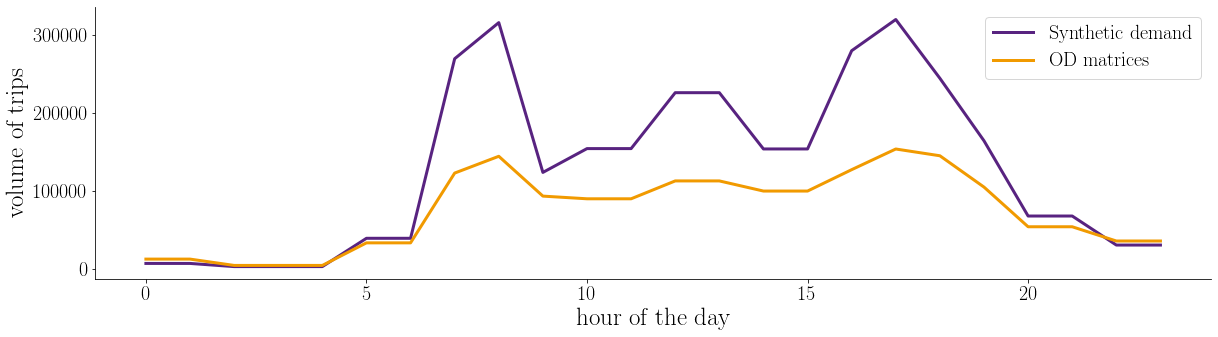

recall: commute data speak of ~500000 commuting persons in this region
Total nb of trips observed in the synthetic pop: 3085661
Total nb of trips observed in mobile phone data: 1787219.0412896487


In [12]:
color_synthpop = (88/255, 35/255, 128/255)
color_odm = (241/255, 154/255, 0/255)
from utils.redistribute_hourly import redistribute_hourly

fig, ax = plt.subplots(figsize=(20,5))

profile = synthpop[ts_cols].sum().values
hours, profile_redistributed = redistribute_hourly(timesteps, profile)
ax.plot(hours, profile_redistributed, color=color_synthpop, linewidth=3, label='Synthetic demand')

hours, profile_redistributed = redistribute_hourly(timesteps, trips_by_hour_odm['vol'])
ax.plot(hours, profile_redistributed, color=color_odm, linewidth=3, label='OD matrices')


ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_xlabel('hour of the day')
ax.set_ylabel('volume of trips')

ax.tick_params(axis='both')
ax.legend()

outpath = os.path.join(config['outfig_dir'], 'hourly_trip_distrib_noscale.pdf')
print('Saving fig to {}'.format(outpath))
plt.savefig(outpath, bbox_inches='tight')

plt.show()
print('recall: commute data speak of ~500000 commuting persons in this region')
print('Total nb of trips observed in the synthetic pop: {}'.format(profile.sum()))
print('Total nb of trips observed in mobile phone data: {}'.format(trips_by_hour_odm['vol'].sum()))

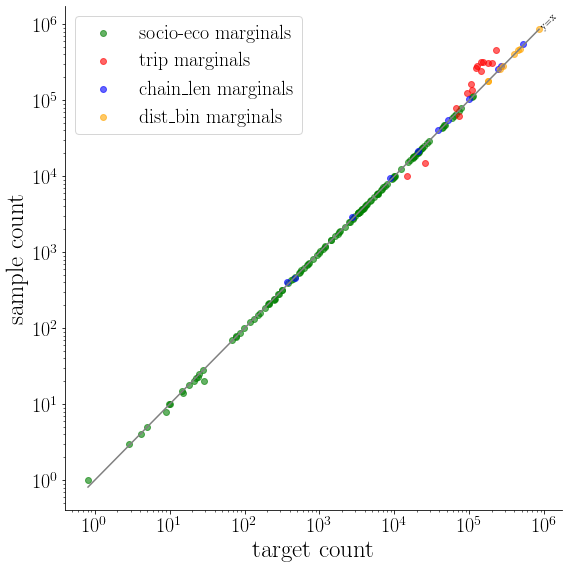

In [13]:
def scatter_fit(x_series, y_series, series_names, series_colors, figsize=8):
    if not (len(x_series)==len(y_series)==len(series_names)==len(series_colors)):
        raise ValueError('please give tuples of same len')
    n = len(x_series)

    fig, ax = plt.subplots(figsize=(figsize,figsize))

    ax.set_xscale('log')
    ax.set_yscale('log')
    max_val = max([xs.max() for xs in x_series] + [ys.max() for ys in y_series])
    min_val = min([xs.min() for xs in x_series] + [ys.min() for ys in y_series])

    for i in range(n):
        ax.scatter(x_series[i], y_series[i], color=series_colors[i], label=series_names[i], alpha=0.6)

    # diagonale:
    ax.plot([min_val, max_val], [min_val, max_val], c=(0.5,0.5,0.5))
    ax.text(max_val, max_val, 'y=x', rotation=45)

    ax.set_xlabel('target count')
    ax.set_ylabel('sample count')
    ax.legend()
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.tight_layout()
    #plt.savefig('/Users/benoit/Desktop/rescaling_pb.pdf', bbox_inches='tight')

    plt.show()


# color_socio = (124/255, 54/255, 156/255) # purple
# color_socio = (0/255, 147/255, 208/255) # blue
# color_trips = (240/255, 222/255,0/255)  # yellow
scatter_fit((X_socio, X_timesteps, X_agendas, X_distbins),
            (Y_socio, Y_timesteps, Y_agendas, Y_distbins),
            ('socio-eco marginals', 'trip marginals', 'chain_len marginals', 'dist_bin marginals'),
            ('g', 'r', 'b', 'orange')
           )

<a id='ipu'></a>
# Jointly rescaling socio-eco & trips
* [back to summary](#summary)

### uniform rescaling of `trips_by_hour_marginal`

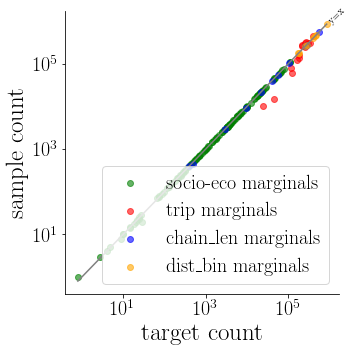

In [14]:
trips_by_hour_marginal_df['vol'] = trips_by_hour_marginal_df['vol']*coef_trips#/coef_socio
coef_trips=1 # just so the cell doesn't mess up everything when ran twice
X_timesteps = trips_by_hour_marginal_df['vol'].values

chainlen_marginal_df['vol'] = chainlen_marginal_df['vol']*coef_agenda
coef_agenda=1 # just so the cell doesn't mess up everything when ran twice
X_agendas = chainlen_marginal_df['vol'].values


socioeco_marginal_df['vol'] = socioeco_marginal_df['vol']*coef_socio
coef_socio=1 # just so the cell doesn't mess up everything when ran twice
X_socio = socioeco_marginal_df['vol'].values

# viz:
scatter_fit((X_socio, X_timesteps, X_agendas, X_distbins),
            (Y_socio, Y_timesteps, Y_agendas, Y_distbins),
            ('socio-eco marginals', 'trip marginals', 'chain_len marginals', 'dist_bin marginals'),
            ('g', 'r', 'b', 'orange'), figsize=5
           )

Saving fig to /Users/benoit/Desktop/hourly_trip_distrib.pdf


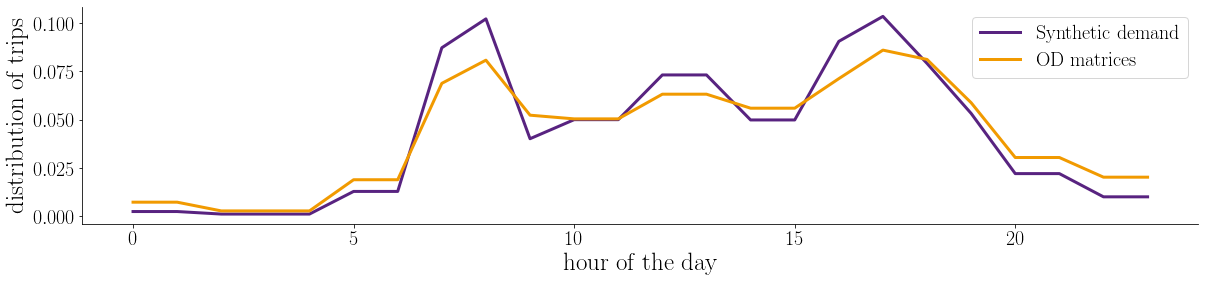

In [16]:

fig, ax = plt.subplots(figsize=(20,4))

profile = synthpop[ts_cols].sum().values
hours, profile_redistributed = redistribute_hourly(timesteps, profile)
ax.plot(hours, profile_redistributed/profile_redistributed.sum(), color=color_synthpop, linewidth=3, label='Synthetic demand')

hours, profile_redistributed = redistribute_hourly(timesteps, X_timesteps)
ax.plot(hours, profile_redistributed/profile_redistributed.sum(), color=color_odm, linewidth=3, label='OD matrices')


ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_xlabel('hour of the day')
ax.set_ylabel('distribution of trips')

ax.tick_params(axis='both')
ax.legend()
#ax.set_title('Number of trips observed on a typical day')

outpath = os.path.join(config['outfig_dir'], 'hourly_trip_distrib.pdf')
print('Saving fig to {}'.format(outpath))
plt.savefig(outpath, bbox_inches='tight')
plt.show()

In [38]:
profile.sum()

3085661

### Creation of `target_df`

In [32]:
socioeco_marginal_df

,marginal,vol
0,"(0, 1, 8, 3)",72831.062889
1,"(0, 1, 6, 1)",18323.563315
2,"(1, 1, 4, 2)",58838.134413
3,"(0, 1, 6, 2)",44907.944540
4,"(1, 1, 7, 0)",109161.131941
...,...,...
122,"(1, 0, 6, 0)",18.169864
123,"(0, 0, 4, 0)",14.733238
124,"(0, 0, 1, 1)",9.731763
125,"(1, 1, 3, 0)",4.112467


In [36]:
len(trips_by_hour_marginal_df) + len(socioeco_marginal_df)

142

In [16]:
target_df = pd.concat([socioeco_marginal_df,
                       trips_by_hour_marginal_df,
                       distbin_marginal_df,
                       chainlen_marginal_df
                      ], ignore_index=True)
target_df = target_df.set_index('marginal')

cols = target_df.index.values
for col in cols:
    if col not in synthpop_gr:
        synthpop_gr[col] = 0
data = synthpop_gr[cols].values

print('{} coefficients'.format(len(synthpop_gr)))
print('{} constraints'.format(len(cols)))

target_df

205904 coefficients
161 constraints


,vol
marginal,
"(0, 1, 8, 3)",72831.062889
"(0, 1, 6, 1)",18323.563315
"(1, 1, 4, 2)",58838.134413
"(0, 1, 6, 2)",44907.944540
"(1, 1, 7, 0)",109161.131941
...,...
chain_len_5,55229.960317
chain_len_6,40177.740403
chain_len_7,9380.853455


<a id='IPU'></a>
## V1: IPU rescaling
* [Back to summary](#summary)

In [17]:

def rescale_IPU(data, target_vect, coefs_init=None, nb_iter=100):
    """
    Scaling a bi-level population with IPU
    """
    if coefs_init is None:
        coefs = np.ones(len(data))
    else:
        coefs = coefs_init.copy()

    losses = np.zeros(nb_iter+1)  # keep log of MSE
    losses[0] = ((np.dot(coefs,data)-target_vect)**2).mean()
    
    for iter_count in tqdm(range(nb_iter)):
        for col in range(len(target_vect)):
            coef = target_vect[col]/(data[:,col] * coefs).sum()
            coefs[data[:,col]>0] *= coef
        losses[iter_count+1] = ((np.dot(coefs, data)-target_vect)**2).mean()

    return coefs, losses


In [18]:
coefs, losses = rescale_IPU(data, target_df['vol'], coefs_init=synthpop_gr['vol'], nb_iter=10)
coefs_ipu = coefs.copy()

100%|███████████████████████████████████████████| 10/10 [01:00<00:00,  6.00s/it]


Saving fig to /Users/benoit/Desktop/rescaling_coefs.pdf


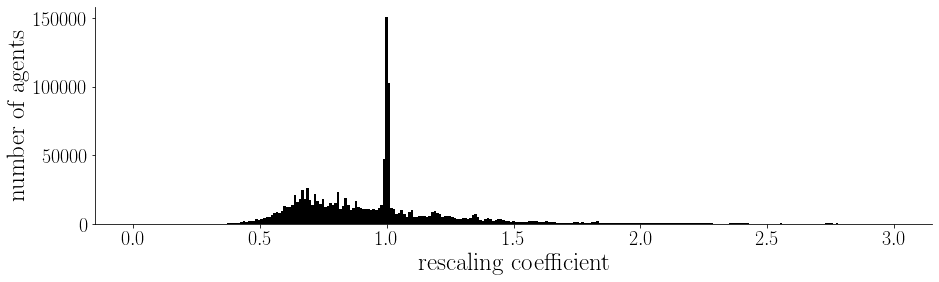

After redistribution: 0 coefs out of 1325654 (0.00%) are below 0.1
Expectaction of censored agents: 171410.60296424103 (12.93%)


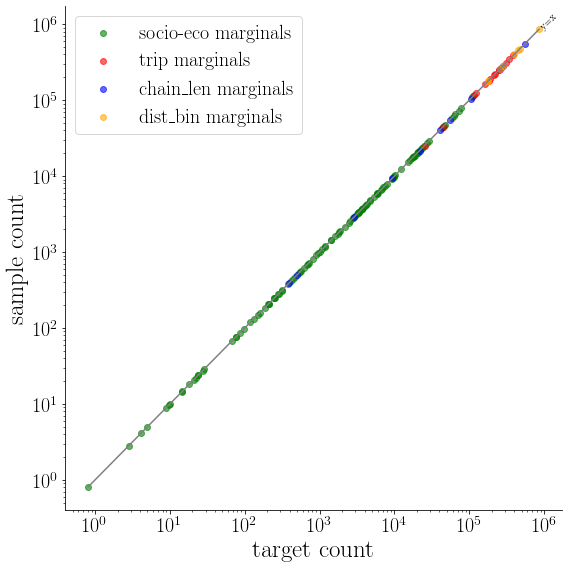

In [19]:
min_val = 0.1
max_val = 10e4


fig, ax = plt.subplots(figsize=(15,4))
coefs_redistributed = np.repeat(coefs_ipu/group_sizes, group_sizes)
ax.hist(coefs_redistributed, bins=np.linspace(0,3,300), color='k')
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_xlabel('rescaling coefficient')
ax.set_ylabel('number of agents')

outpath = os.path.join(config['outfig_dir'], 'rescaling_coefs.pdf')
print('Saving fig to {}'.format(outpath))
plt.savefig(outpath, bbox_inches='tight')
plt.show()

print('After redistribution: {} coefs out of {} ({:.2%}) are below {}'.format((coefs_redistributed<min_val).sum(),
                                                                          len(coefs_redistributed),
                                                                          (coefs_redistributed<min_val).sum()/len(coefs_redistributed),
                                                                          min_val
                                                                         ))
censored_proba = np.maximum(0, 1-np.array(coefs_redistributed)).sum()
print('Expectaction of censored agents: {} ({:.2%})'.format(censored_proba, censored_proba/len(coefs_redistributed)))

Y_socio = coefs @ synthpop_gr[mod_socio_eco_cols].values

X_timesteps = trips_by_hour_marginal_df['vol'].values
Y_timesteps = coefs @ synthpop_gr[ts_cols].values

X_distbins = distbin_marginal_df['vol'].values
Y_distbins = coefs @ synthpop_gr[distbin_cols].values


chainlen_marginal_pop_df = pd.DataFrame({'marginal':mod_agenda_cols, 
                                         'vol_pop':coefs @ synthpop_gr[mod_agenda_cols].values})
chainlen_marginal_pop_df = chainlen_marginal_pop_df.merge(chainlen_marginal_df, 
                                                          on='marginal', how='outer').fillna(0)
Y_agendas = chainlen_marginal_pop_df['vol_pop'].values
X_agendas = chainlen_marginal_pop_df['vol'].values

scatter_fit((X_socio, X_timesteps, X_agendas, X_distbins),
            (Y_socio, Y_timesteps, Y_agendas, Y_distbins),
            ('socio-eco marginals', 'trip marginals', 'chain_len marginals', 'dist_bin marginals'),
            ('g', 'r', 'b', 'orange')
           )



<a id='integration'></a>
# Setting coef to synthpop with activity chain
* weird bug : if assigning coef before the merge, the coefs are not in the right order after the merge
* so we have to join here and then assign the column coef, 
* instead of storing separate tables for census and for activity chains
* so we also have to reload activity chains to get modes and motives
* [back to summary](#summary)

15:51:18	Loading activity chains...
00:00:00	Loading synthpop...
00:00:00	Merging census with activity chains...
00:00:03	Dividing coefs for individual agents...
00:00:04	Merging coefs into census...
00:00:10	0 (0.00%)agents with a coef<0.1


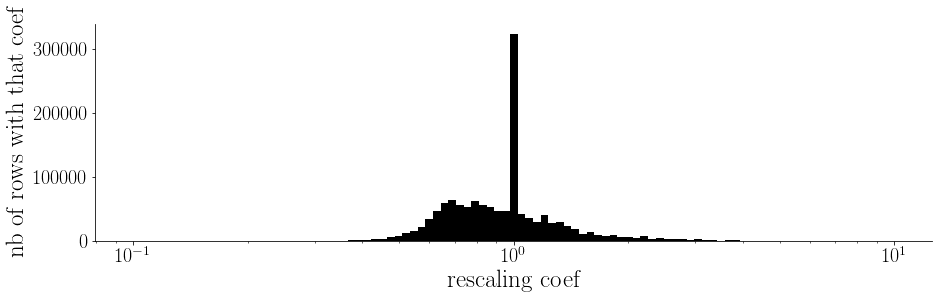

00:00:11	Integerisation (TRS)...
00:00:11	Dropping null coefs...
00:00:11	not sampled : dropping 171124 agent rows out of 1325654 (13%)
coef
1.0    1015608
2.0     116064
3.0      17351
4.0       3590
5.0        760
6.0        473
7.0        338
8.0        328
9.0         18
dtype: int64
00:00:12	Flattening to get 1 row per agent...
00:00:16	1325939 rows
00:00:16	Work complete !


In [20]:
c=Chrono('Loading activity chains...')
activity_chains = pd.read_csv(activity_chain_path, dtype={'chain_len':int})

c.write('Loading synthpop...')
census_ori = pd.read_csv(synthpop_path)

c.write('Merging census with activity chains...')
census_ori_with_activity_chain = census_ori.merge(activity_chains, left_on='id_agenda', right_on='id_per')
census_ori_with_activity_chain = census_ori_with_activity_chain.drop(columns=['id_per'])

c.write('Dividing coefs for individual agents...')
# coef is meant for the group, so each indistinguishable agent in the group must have an equal share of the coef
synthpop_gr['coef'] = coefs/synthpop_gr['vol']
synthpop_gr['id_per'] = id_list
synthpop_gr_expl = synthpop_gr.explode('id_per')

c.write('Merging coefs into census...')
census_ori_with_activity_chain = census_ori_with_activity_chain.merge(synthpop_gr_expl[['id_per', 'coef']], 
                                                                     left_index=True,
                                                                    right_on='id_per'
                                                                     ).reset_index(drop=True)
min_val = 0.1
max_val = 10

c.write('{} ({:.2f}%)agents with a coef<{}'.format(
    (census_ori_with_activity_chain['coef']<min_val).sum(),
    100*(census_ori_with_activity_chain['coef']<min_val).mean(),
    min_val))

fig, ax = plt.subplots(figsize=(15,4))
ax.hist(census_ori_with_activity_chain['coef'],
        bins=np.logspace(np.log10(min_val),np.log10(max_val),100), color='k')
ax.set_xscale('log')
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_xlabel('rescaling coef')
ax.set_ylabel('nb of rows with that coef')
plt.show()


c.write('Integerisation (TRS)...')
rng = np.random.default_rng()

def TRS(coef_col):
    """
    integerize by considering the integer part is a fixed number 
    and the decimal part is a probability of existence
    """
    return np.floor(coef_col) + (rng.random(size=len(coef_col)) <= coef_col%1)  

census_ori_with_activity_chain['coef'] = TRS(census_ori_with_activity_chain['coef'])


c.write('Dropping null coefs...')
to_drop = census_ori_with_activity_chain[census_ori_with_activity_chain['coef']==0].index
c.write('not sampled : dropping {} agent rows out of {} ({:.2g}%)'.format(len(to_drop), 
                                                             len(census_ori_with_activity_chain),
                                                             100*len(to_drop)/len(census_ori_with_activity_chain)))
census_ori_with_activity_chain = census_ori_with_activity_chain.drop(to_drop)

print(census_ori_with_activity_chain.groupby('coef').size())


c.write('Flattening to get 1 row per agent...')
census_ori_with_activity_chain = (census_ori_with_activity_chain
              .iloc[np.repeat(np.arange(len(census_ori_with_activity_chain)),
                              census_ori_with_activity_chain['coef'])]
              .reset_index(drop=True)
             .drop(columns=['coef', 'id_per']))
c.write('{} rows'.format(len(census_ori_with_activity_chain)))

census_ori_with_activity_chain['agent_id'] = np.arange(len(census_ori_with_activity_chain))

c.done()



### Checking marginal fit after integerization

In [21]:

# Socio-eco marginals : merging with target so we keep track of socio-eco values that are not represented anymore
pop_marginal = census_ori_with_activity_chain.groupby(per_cols).size().rename('intvol').reset_index()
pop_marginal['marginal'] = pop_marginal[['gender','has_car','occupation','age']].apply(lambda r: str(tuple(r)), axis=1)
print('{} different socioeco values in population'.format(len(pop_marginal)))
print('{} different socioeco values in target'.format(len(socioeco_marginal_df)))
pop_marginal = pop_marginal.merge(socioeco_marginal_df, on='marginal', how='outer')
pop_marginal['intvol'] = pop_marginal['intvol'].fillna(0)
X_socio = pop_marginal['vol'].values
Y_socio = pop_marginal['intvol'].values

 
Y_timesteps = np.zeros(len(timesteps))
for t, ts in enumerate(timesteps):
    for i in range(1, max_chain_len+1):
        Y_timesteps[t] += (census_ori_with_activity_chain['dep_{}_time'.format(i)]==ts).sum()


# distance bins marginals
Y_distbins = np.zeros(len(distbins))
for b, bin_col in enumerate(distbins):
    for i in range(1, max_chain_len+1):
        Y_distbins[b] += (census_ori_with_activity_chain['dep_{}_distbin'.format(i)]==bin_col).sum()

print(Y_distbins)


# Chain len marginals
Y_agendas = census_ori_with_activity_chain.groupby('chain_len').size().rename('vol').reset_index()
Y_agendas = Y_agendas.merge(pd.DataFrame({'chain_len':np.arange(len(X_agendas))}), on='chain_len', how='outer')
Y_agendas = Y_agendas.fillna(0)
Y_agendas['chain_len'] = Y_agendas['chain_len'].astype(str)  # hmprf
Y_agendas = Y_agendas.sort_values('chain_len')  # hmprf
Y_agendas = Y_agendas['vol'].values

127 different socioeco values in population
127 different socioeco values in target
[451949. 180673. 401004. 857269. 475205. 283811. 176370. 260133.]


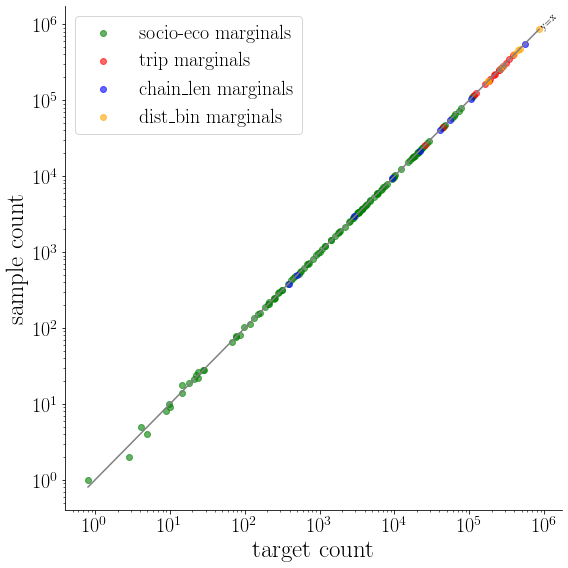

In [22]:
scatter_fit((X_socio, X_timesteps, X_agendas, X_distbins),
            (Y_socio, Y_timesteps, Y_agendas, Y_distbins),
            ('socio-eco marginals', 'trip marginals', 'chain_len marginals', 'dist_bin marginals'),
            ('g', 'r', 'b', 'orange')
           )

<a id='export'></a>
# Exportation
* [back to summary](#summary)

In [23]:
out_path = os.path.join(config['outdata_dir']['path'], 
                        config['outdata_dir']['synthpop_rescaled_filename'])

print(datetime.datetime.now())
census_ori_with_activity_chain.to_csv(out_path, index=False)
print('Exporting to: {}'.format(out_path))
census_ori_with_activity_chain.head()

2023-12-19 15:51:36.894980
Exporting to: /Users/benoit/Desktop/Pro/210526-fusion/outdata/synthpop/synthpop_statmatch_rescaleipu.csv


,iris_or_commune,gender,has_car,occupation,age,home_status,main_transport_work,id_agenda,dep_0_motif,dep_0_zone,...,dep_7_distbin,dep_8_distbin,dep_9_distbin,dep_10_distbin,autonomy,work_tm_in_agenda,work_in_agenda,study_in_agenda,need_commute,agent_id
0,69288,0,1,6,1,0,2,1320021221,0.0,132002.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,0
1,692770103,1,1,4,2,2,2,1320021221,0.0,132002.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,1
2,690890201,0,1,7,0,0,-1,1320021221,0.0,132002.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,2
3,692730103,0,1,7,0,0,-1,1320021221,0.0,132002.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,3
4,691490301,0,1,7,0,0,-1,1320021221,0.0,132002.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,4


<a id='viz'></a>
# Visualisation
* [back to summary](#summary)

In [28]:
import geopandas as gpd

# census marginals acting as ground truth
marginal_out_path = os.path.join(config['outdata_dir']['path'], 
                         config['outdata_dir']['socioeco_marginals_filename'])
census_socio_eco = pd.read_csv(marginal_out_path).groupby(per_cols)['IPONDI'].sum().reset_index()
census_socio_eco['vol_census'] = census_socio_eco['IPONDI'] / census_socio_eco['IPONDI'].sum()
census_socio_eco = census_socio_eco.drop(columns=['IPONDI'])

# any of our synthpop, they all have the same socio-eco comp
synthpop = census_ori_with_activity_chain
synthpop_socioeco = synthpop.groupby(per_cols).size().reset_index()
synthpop_socioeco['vol_synthpop'] = synthpop_socioeco[0]/synthpop_socioeco[0].sum()
synthpop_socioeco = synthpop_socioeco.drop(columns=[0])

# egt
egt_path = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['HTS_filtered_filename'])
egt = pd.read_csv(egt_path, dtype={'id_per':str})
egt_socioeco = egt.groupby(per_cols)['scaling_factor_person'].sum().reset_index()
egt_socioeco['vol_egt'] = egt_socioeco['scaling_factor_person']/egt_socioeco['scaling_factor_person'].sum()
egt_socioeco = egt_socioeco.drop(columns=['scaling_factor_person'])

compdf = census_socio_eco.merge(synthpop_socioeco, on=per_cols, how='outer').fillna(0)
compdf = compdf.merge(egt_socioeco, on=per_cols, how='outer').fillna(0)
compdf

,gender,has_car,occupation,age,vol_census,vol_synthpop,vol_egt
0,0,0,0,0,0.002532,0.002516,0.000445
1,0,0,0,1,0.002241,0.002233,0.004200
2,0,0,0,2,0.005370,0.005382,0.006249
3,0,0,0,3,0.000685,0.000687,0.000333
4,0,0,1,1,0.000007,0.000008,0.000000
...,...,...,...,...,...,...,...
122,1,1,7,1,0.021730,0.021708,0.022604
123,1,1,7,2,0.002684,0.002672,0.000710
124,1,1,7,3,0.000409,0.000411,0.000000
125,1,1,8,2,0.002534,0.002538,0.003673


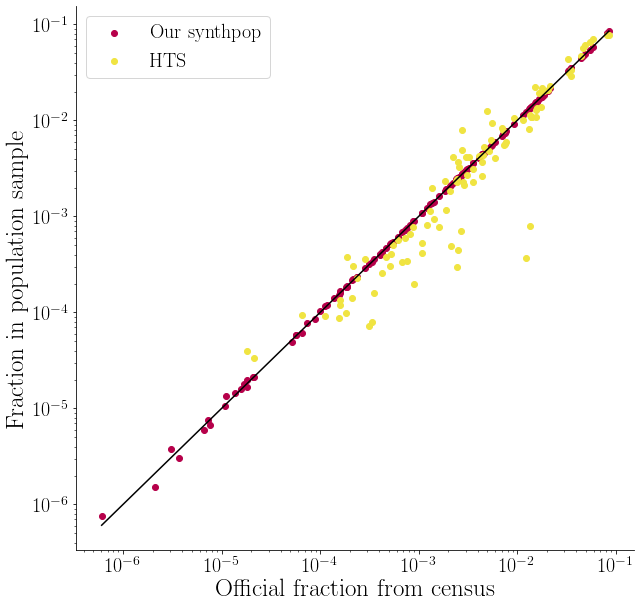

In [33]:
color_dict = {
    'census' : (0,0,0),
    'synthpop' : (182/255,0/255,74/255),
    'synthpop_pre_ipu' : (88/255, 35/255, 128/255),
    'EMD' : (170/255, 204/255, 0/255),
    #'HTS' : (0/255, 158/255, 15/255),  # Green Wong for colorblindsafe palette 
    'HTS' : (240/255, 228/255, 66/255),  # Green Wong for colorblindsafe palette 
    'odm' : (241/255, 154/255, 0/255),
    'eqasim' : (48/255, 190/255, 242/255)
}


fig, ax = plt.subplots(figsize=(10,10))

minval = min(compdf['vol_census'][compdf['vol_census']>0].min(),
             compdf['vol_synthpop'][compdf['vol_synthpop']>0].min(),
             compdf['vol_egt'][compdf['vol_egt']>0].min())

maxval = max(compdf['vol_census'].max(),compdf['vol_synthpop'].max(),compdf['vol_egt'].max())
ax.plot([minval,maxval], [minval, maxval], color='k')

ax.scatter(compdf['vol_census'], compdf['vol_synthpop'], color=(182/255,0/255,74/255), label='Our synthpop')
ax.scatter(compdf['vol_census'], compdf['vol_egt'], color=(240/255, 228/255, 66/255), label='HTS')

ax.set_xscale('log')
ax.set_yscale('log')

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel('Official fraction from census')
ax.set_ylabel('Fraction in population sample')
plt.legend()

    
outpath = os.path.join(config['outfig_dir'], 'socioecofit.pdf')
plt.savefig(outpath, bbox_inches='tight')
plt.show()

In [26]:
from IPython.core.display import display, HTML
from utils.agenda_display import agenda_display

display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

cols_illu = [

'iris_or_commune',
'gender',
'has_car',
'occupation',
'age',
'home_status',
'chain_len',
'dep_1_mode',
'dep_1_motif',
'dep_1_time',
'dep_2_mode',
'dep_2_motif',
'dep_2_time',
'dep_3_mode',
'dep_3_motif',
'dep_3_time',
'dep_4_mode',
'dep_4_motif',
'dep_4_time',]

df_illu = census_ori_with_activity_chain[census_ori_with_activity_chain['chain_len']>2][cols_illu].sample(10)
with pd.option_context('display.max_columns', None):
    agenda_display(df_illu.fillna(-1).astype({col:int for col in df_illu.columns}).replace({-1:' '}))


,iris_or_commune,gender,has_car,occupation,age,home_status,chain_len,dep_1_mode,dep_1_motif,dep_1_time,dep_2_mode,dep_2_motif,dep_2_time,dep_3_mode,dep_3_motif,dep_3_time,dep_4_mode,dep_4_motif,dep_4_time
1072042,693860301,0,1,2,2,0,3,🚗,🏭,5h,🚗,🛍️,18h,🚗,🏠,20h,,,h
1260095,693870101,0,0,7,2,2,4,🚌,🏭,5h,👣,🍻,12h,👣,🏭,12h,🚌,🏠,17h
497494,692860402,0,1,6,2,2,3,🚌,🍻,14h,🚌,🍻,17h,🚌,🏠,19h,,,h
1110719,693890401,1,1,8,3,0,4,🚗,🏭,8h,🚗,🏠,12h,🚗,🏭,12h,🚗,🏠,18h
254933,692660301,1,1,5,2,2,4,👣,📚,8h,👣,🏠,12h,👣,🍻,12h,👣,🏠,16h
24555,691000101,1,1,5,1,0,4,👣,📚,8h,👣,🏠,10h,👣,🍻,12h,👣,🏠,12h
1014318,692661401,1,0,0,0,2,4,🚗,🍻,2h,🚗,🏠,2h,🚗,🛍️,12h,🚗,🏠,14h
139077,693830602,1,1,7,0,2,4,🚌,📚,8h,🚌,🍻,16h,🚌,🛍️,18h,👣,🏠,19h
563605,693830801,1,1,7,0,2,4,🚗,📚,9h,🚗,🏠,17h,🚗,🍻,19h,🚗,🏠,22h
1093958,690290204,0,1,7,1,2,4,🚌,🏭,9h,🚌,🏠,18h,🚌,🍻,19h,🚌,🏠,22h


In [27]:
display(HTML("<style>.container { width:59.8% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
